In [1]:
# !pip install segmentation-models-pytorch

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tifffile as tiff
import torch
import zipfile
from PIL import Image
import segmentation_models_pytorch as smp

In [4]:
with zipfile.ZipFile('/content/drive/MyDrive/Data set/segmentation water.zip' , 'r') as file :
  file.extractall('/content/water_segmentation')

# load the dataset and there labels


In [5]:
def load_data_labels(data_path):

  image_path = os.path.join(data_path , 'images')
  label_path = os.path.join(data_path , 'labels')


  images = []
  labels = []

  for filename in os.listdir(image_path):
    image = os.path.join(image_path , filename)
    images.append((image , int(filename.split('.')[0])))

  for filename in os.listdir(label_path):
    if '_' in filename:
        continue
    image = os.path.join(label_path , filename)
    labels.append((image , int(filename.split('.')[0])))

  images.sort(key=lambda x:x[1])
  labels.sort(key=lambda x:x[1])

  final_images = []
  final_labels = []

  for i in range(len(images)):
    image = tiff.imread(images[i][0])
    final_images.append(image)

    label = Image.open(labels[i][0])
    # Convert PIL Image to numpy array and then to torch tensor
    final_labels.append(np.array(label))

  return final_images , final_labels

file_path = '/content/water_segmentation/data'

d_img , d_label =  load_data_labels(file_path)

# Convert numpy arrays to PyTorch tensors
d_img = torch.tensor(np.array(d_img), dtype=torch.float32)
d_label = torch.tensor(np.array(d_label), dtype=torch.long)


print(f"Loaded {len(d_img)} images with shape {d_img[0].shape} and {len(d_label)} labels with shape {d_label[0].shape}")

Loaded 306 images with shape torch.Size([128, 128, 12]) and 306 labels with shape torch.Size([128, 128])


# visualize the channels of every image and ground truth

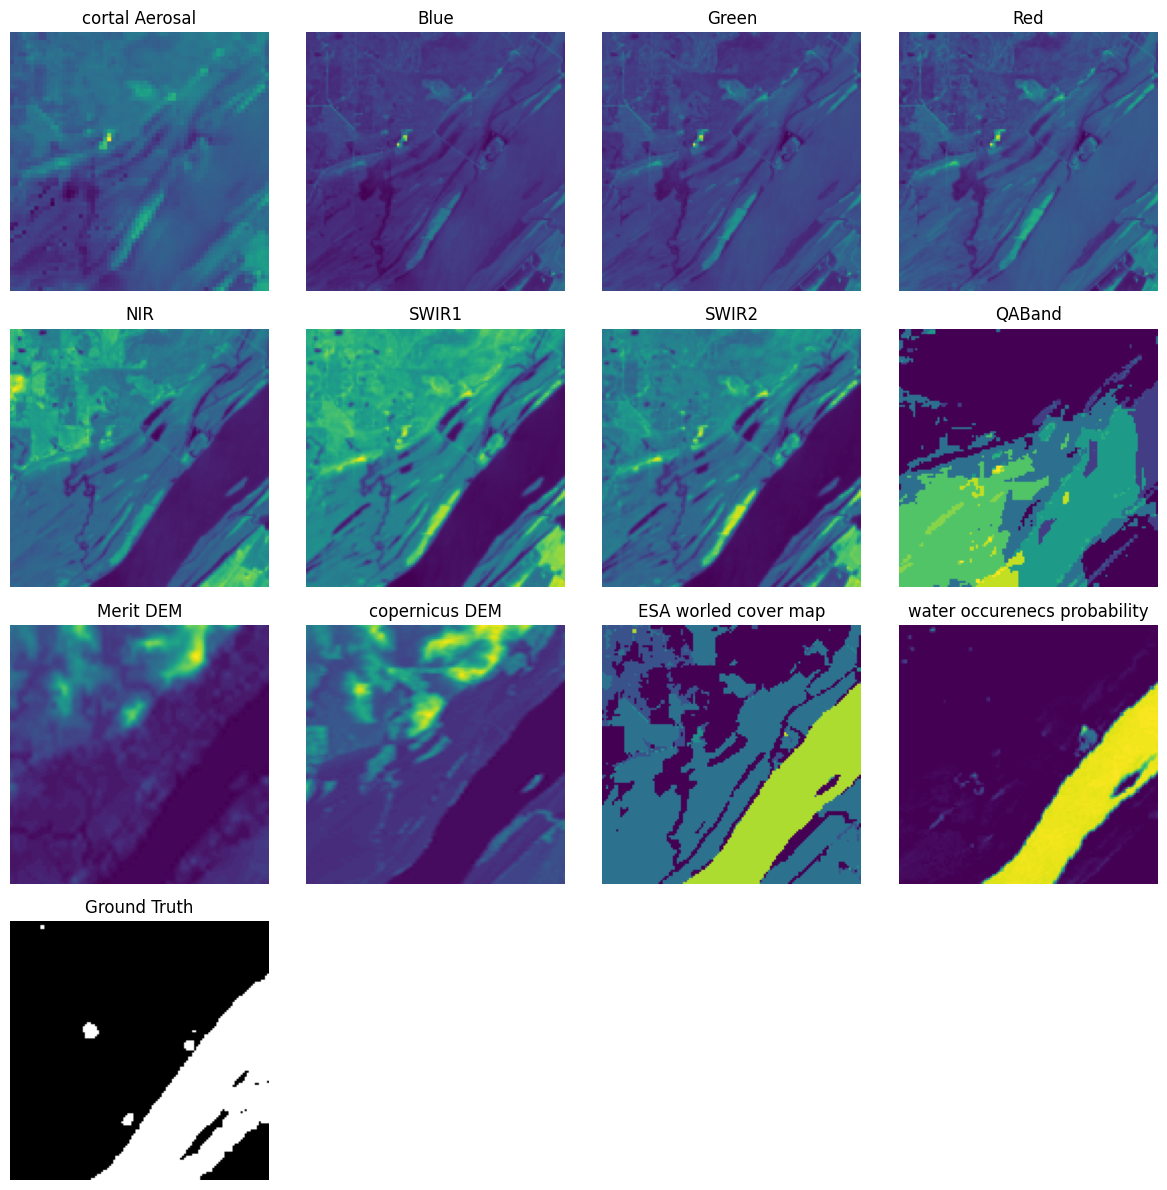

In [6]:
name_of_channels = ['cortal Aerosal' , 'Blue' , 'Green' , 'Red' , 'NIR' , 'SWIR1' , 'SWIR2' , 'QABand' , 'Merit DEM' ,
                    'copernicus DEM' , 'ESA worled cover map' ,'water occurenecs probability']
plt.figure(figsize=(12, 12))
for i in range(d_img.shape[3]):
  plt.subplot(4, 4, i + 1)
  plt.imshow(d_img[224, :, :, i])
  plt.title(f'{name_of_channels[i]}')
  plt.axis('off')

# Display the ground truth label
plt.subplot(4, 4, 13)
plt.imshow(d_label[224, :, :], cmap='gray')
plt.title('Ground Truth')
plt.axis('off')

plt.tight_layout()
plt.show()

# Preprocessing

In [7]:
# normalization

def apply_normalization(channel):
  # Ensure channel is a float32 tensor for calculation
  channel = channel.float()
  min_val = torch.min(channel)
  max_val = torch.max(channel)

  # Avoid division by zero if max_val is equal to min_val
  if torch.equal(max_val, min_val):
      return torch.zeros_like(channel) # Or return channel if no change is desired
  return (channel - min_val) / (max_val - min_val)

normalized_channels = []
for i in range(d_img.shape[3]):
  normalized_channel = apply_normalization(d_img[:,:,:,i])
  normalized_channels.append(normalized_channel)

# Stack the normalized channels back into a single tensor
d_img = torch.stack(normalized_channels, dim=-1)


# You can check the min and max values of the normalized tensor
print(f"Minimum value after normalization: {torch.min(d_img)}")
print(f"Maximum value after normalization: {torch.max(d_img)}")

Minimum value after normalization: 0.0
Maximum value after normalization: 1.0


In [8]:
# create NDWI

green = d_img[:,:,:,2]
nir = d_img[:,:,:,4]

# Avoid division by zero by adding a small epsilon
epsilon = 1e-8
NDWI = (green - nir) / (green + nir + epsilon)


# Expand dimensions of NDWI to match d_img for concatenation
NDWI = torch.unsqueeze(NDWI, dim=-1)

# Concatenate the original image tensor with the NDWI channel
d_img = torch.cat([d_img, NDWI], dim=-1)

print(d_img.shape)

torch.Size([306, 128, 128, 13])


In [9]:
# Data augmentation
import albumentations as A

augment_steps = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.VerticalFlip(p=0.5)
    ]
)

# Remove the extra dimension from labels
# d_label = torch.unsqueeze(d_label , dim = -1)

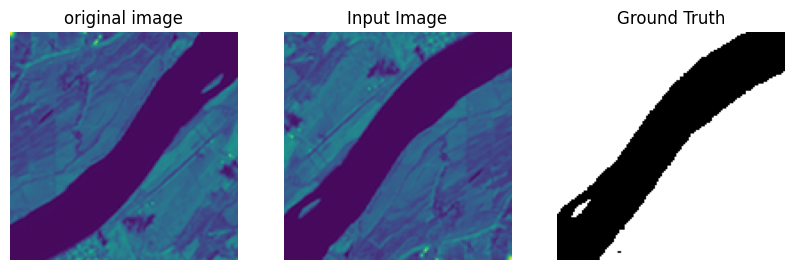

In [10]:
# test the augmentation

augmneted_data = augment_steps(image = d_img[305].numpy() , mask = d_label[305].numpy())

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(d_img[305,:,:,6])
plt.title("original image")
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(augmneted_data['image'][:,:,6])
plt.title('Input Image')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(augmneted_data['mask'].squeeze(), cmap='binary')
plt.title('Ground Truth')
plt.axis('off')
plt.show()

In [11]:
# split the dataset
from sklearn.model_selection import train_test_split

train_images , test_images , train_labels , test_labels = train_test_split(
    d_img.numpy() ,
    d_label.numpy() ,
    test_size = 0.2 ,
    random_state = 42 ,
    shuffle = True)

In [12]:
train_images , val_images , train_labels , val_labels = train_test_split(
    train_images ,
    train_labels ,
    test_size = 0.2 ,
    random_state = 42 ,
    shuffle = True)

In [13]:
# now i will just apply augmentation on training data

augmented_images = []
augmented_labels = []

for i in range(train_images.shape[0]):
  augmneted_data = augment_steps(image = train_images[i] , mask = train_labels[i])
  augmented_images.append(augmneted_data['image'])
  augmented_labels.append(augmneted_data['mask'])

# convert to tensors to be more fast in training than numpy array
train_images =torch.tensor(np.array(augmented_images) , dtype=torch.float32)
train_labels = torch.tensor(np.array(augmented_labels) , dtype = torch.long)



#################################
# Note : try to reduce the dimantion by pca to 3 channels
#################################

In [14]:
from torch.utils.data import Dataset

class WaterDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Use clone().detach() and remove the extra unsqueeze
        image = torch.tensor(self.images[idx]).clone().detach().float().permute(2, 0, 1)  # (C,H,W)
        mask = torch.tensor(self.masks[idx]).clone().detach().float().unsqueeze(0)  # (1,H,W)

        if self.transform:
            # Note: If transform expects a channel dimension for the mask, you might need to unsqueeze here before the transform and then squeeze after.
            # For now, assuming transform works with (H,W) mask or handles the channel internally.
            image = self.transform(image)


        return image, mask

In [15]:
from torch.utils.data import DataLoader

train_dataset = WaterDataset(train_images , train_labels)
val_dataset = WaterDataset(val_images , val_labels)
test_dataset = WaterDataset(test_images , test_labels)

train_loader = DataLoader(train_dataset , batch_size = 32 , shuffle = True)
val_loader = DataLoader(val_dataset , batch_size = 32 , shuffle = False)
test_loader = DataLoader(test_dataset , batch_size = 32 , shuffle = False)

In [16]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        # outputs = outputs.long()
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)


In [17]:
def iou_score(preds, targets, eps=1e-6):
    # Cast to boolean before performing bitwise operations
    preds = preds.bool()
    targets = targets.bool()

    intersection = (preds & targets).float().sum((1, 2, 3))
    union = (preds | targets).float().sum((1, 2, 3))
    return ((intersection + eps) / (union + eps)).mean().item()

def dice_coeff(preds, targets, epsilon=1e-6):
    preds = preds.float()
    targets = targets.float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
    dice = (2. * intersection + epsilon) / (union + epsilon)
    return dice.mean()

In [18]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0
    dice_total = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            # outputs = outputs.long()
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            dice_total += dice_coeff(preds, masks)

    return val_loss / len(dataloader), dice_total / len(dataloader)


In [19]:
model1 = smp.DeepLabV3(
    encoder_name= 'resnet34',
    encoder_weights='imagenet',
    in_channels=13,
    classes=1,
    activation=None, # None
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [20]:
def predict(model, image, device):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)  # Add batch dimension
        output = model(image)
        # outputs = outputs.long()
        pred = torch.sigmoid(output)
        return pred.squeeze().cpu().numpy()


In [21]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
# Training loop
num_epochs = 50
model1.to(device)

train_losses = []
val_losses = []
val_dices = []

for epoch in range(num_epochs):
    train_loss = train_model(model1, train_loader, criterion, optimizer, device)
    val_loss, val_dice = evaluate_model(model1, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_dices.append(val_dice)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val dice: {val_dice:.4f}")

# Evaluate on test set
test_loss, test_dice = evaluate_model(model1, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}, Test dice: {test_dice:.4f}")

/tmp/ipython-input-14-1550219719.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(self.images[idx]).clone().detach().float().permute(2, 0, 1)  # (C,H,W)
/tmp/ipython-input-14-1550219719.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(self.masks[idx]).clone().detach().float().unsqueeze(0)  # (1,H,W)


Epoch 1/50: Train Loss: 0.8343, Val Loss: 6.1425, Val dice: 0.3601
Epoch 2/50: Train Loss: 0.4375, Val Loss: 2.8940, Val dice: 0.4243
Epoch 3/50: Train Loss: 0.3809, Val Loss: 0.4000, Val dice: 0.4324
Epoch 4/50: Train Loss: 0.3417, Val Loss: 0.4575, Val dice: 0.3808
Epoch 5/50: Train Loss: 0.3881, Val Loss: 0.6407, Val dice: 0.4974
Epoch 6/50: Train Loss: 0.3066, Val Loss: 0.4241, Val dice: 0.4464
Epoch 7/50: Train Loss: 0.3024, Val Loss: 0.3396, Val dice: 0.4512
Epoch 8/50: Train Loss: 0.3051, Val Loss: 0.3582, Val dice: 0.4646
Epoch 9/50: Train Loss: 0.2826, Val Loss: 0.3672, Val dice: 0.3931
Epoch 10/50: Train Loss: 0.3117, Val Loss: 0.3502, Val dice: 0.4249
Epoch 11/50: Train Loss: 0.2766, Val Loss: 0.3064, Val dice: 0.4476
Epoch 12/50: Train Loss: 0.2437, Val Loss: 0.2741, Val dice: 0.5013
Epoch 13/50: Train Loss: 0.2624, Val Loss: 0.2665, Val dice: 0.4856
Epoch 14/50: Train Loss: 0.2584, Val Loss: 0.3255, Val dice: 0.4876
Epoch 15/50: Train Loss: 0.2250, Val Loss: 0.3694, Val di

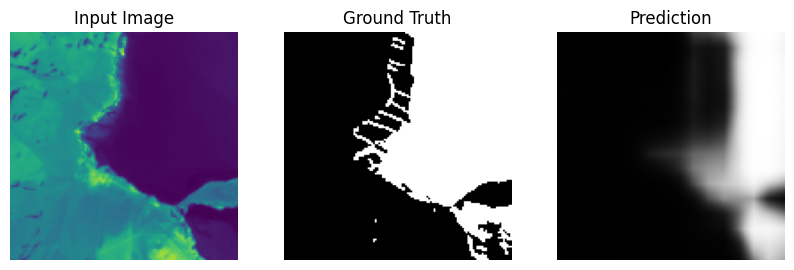

In [23]:
# Example prediction
# Get one image from the test set
sample_image, sample_mask = test_dataset[0]
prediction = predict(model1, sample_image, device)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(sample_image.permute(1, 2, 0)[:, :, 6])
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sample_mask.squeeze().numpy(), cmap='gray')
plt.title("Ground Truth")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(prediction, cmap='gray')
plt.title("Prediction")
plt.axis('off')

plt.show()

In [24]:
model2 = smp.Linknet(
    encoder_name= 'resnet34',
    encoder_weights='imagenet',
    in_channels=13,
    classes=1,
    activation=None,
)

In [25]:
model2.to(device)

train_losses = []
val_losses = []
val_dices = []
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

for epoch in range(num_epochs):
    train_loss = train_model(model2, train_loader, criterion, optimizer, device)
    val_loss, val_dice = evaluate_model(model2, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_dices.append(val_dice)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val dice: {val_dice:.4f}")

# Evaluate on test set
test_loss, test_dice = evaluate_model(model2, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}, Test dice: {test_dice:.4f}")

/tmp/ipython-input-14-1550219719.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(self.images[idx]).clone().detach().float().permute(2, 0, 1)  # (C,H,W)
/tmp/ipython-input-14-1550219719.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(self.masks[idx]).clone().detach().float().unsqueeze(0)  # (1,H,W)


Epoch 1/50: Train Loss: 0.6766, Val Loss: 0.7212, Val dice: 0.3629
Epoch 2/50: Train Loss: 0.4623, Val Loss: 0.9995, Val dice: 0.3567
Epoch 3/50: Train Loss: 0.3756, Val Loss: 0.9337, Val dice: 0.3339
Epoch 4/50: Train Loss: 0.3401, Val Loss: 0.6343, Val dice: 0.3516
Epoch 5/50: Train Loss: 0.3410, Val Loss: 4.6386, Val dice: 0.3352
Epoch 6/50: Train Loss: 0.2937, Val Loss: 1.1526, Val dice: 0.4943
Epoch 7/50: Train Loss: 0.2604, Val Loss: 0.4611, Val dice: 0.5167
Epoch 8/50: Train Loss: 0.2553, Val Loss: 0.2975, Val dice: 0.5104
Epoch 9/50: Train Loss: 0.2772, Val Loss: 0.3512, Val dice: 0.5266
Epoch 10/50: Train Loss: 0.2678, Val Loss: 0.2870, Val dice: 0.5417
Epoch 11/50: Train Loss: 0.2383, Val Loss: 0.2848, Val dice: 0.5477
Epoch 12/50: Train Loss: 0.2460, Val Loss: 0.2808, Val dice: 0.5375
Epoch 13/50: Train Loss: 0.2347, Val Loss: 0.2841, Val dice: 0.5370
Epoch 14/50: Train Loss: 0.2091, Val Loss: 0.3331, Val dice: 0.5259
Epoch 15/50: Train Loss: 0.2608, Val Loss: 0.2528, Val di

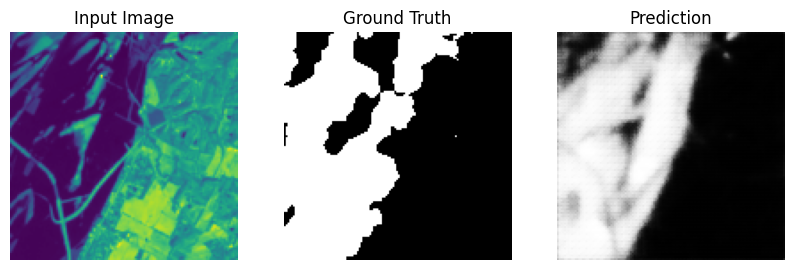

In [26]:
# Get one image from the test set
sample_image, sample_mask = test_dataset[5]
prediction = predict(model2, sample_image, device)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(sample_image.permute(1, 2, 0)[:, :, 6])
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sample_mask.squeeze().numpy(), cmap='gray')
plt.title("Ground Truth")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(prediction , cmap='gray')
plt.title("Prediction")
plt.axis('off')

plt.show()

In [27]:
model3 = smp.FPN(
    encoder_name= 'resnet34',
    encoder_weights='imagenet',
    in_channels=13,
    classes=1,
    activation=None,
)

In [28]:
model3.to(device)

train_losses = []
val_losses = []
val_dices = []
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)

for epoch in range(num_epochs):
    train_loss = train_model(model3, train_loader, criterion, optimizer, device)
    val_loss, val_dice = evaluate_model(model3, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_dices.append(val_dice)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val dice: {val_dice:.4f}")

# Evaluate on test set
test_loss, test_dice = evaluate_model(model3, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}, Test dice: {test_dice:.4f}")

/tmp/ipython-input-14-1550219719.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(self.images[idx]).clone().detach().float().permute(2, 0, 1)  # (C,H,W)
/tmp/ipython-input-14-1550219719.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(self.masks[idx]).clone().detach().float().unsqueeze(0)  # (1,H,W)


Epoch 1/50: Train Loss: 1.8241, Val Loss: 2.7209, Val dice: 0.3625
Epoch 2/50: Train Loss: 0.4001, Val Loss: 0.5842, Val dice: 0.3575
Epoch 3/50: Train Loss: 0.3194, Val Loss: 0.4510, Val dice: 0.4929
Epoch 4/50: Train Loss: 0.3060, Val Loss: 0.3037, Val dice: 0.4796
Epoch 5/50: Train Loss: 0.3161, Val Loss: 0.2987, Val dice: 0.4923
Epoch 6/50: Train Loss: 0.3104, Val Loss: 0.3748, Val dice: 0.4722
Epoch 7/50: Train Loss: 0.2988, Val Loss: 0.3321, Val dice: 0.4924
Epoch 8/50: Train Loss: 0.2674, Val Loss: 0.3199, Val dice: 0.4946
Epoch 9/50: Train Loss: 0.2823, Val Loss: 0.2867, Val dice: 0.5076
Epoch 10/50: Train Loss: 0.3921, Val Loss: 0.3684, Val dice: 0.5147
Epoch 11/50: Train Loss: 0.3134, Val Loss: 0.3617, Val dice: 0.5118
Epoch 12/50: Train Loss: 0.3213, Val Loss: 0.3573, Val dice: 0.4864
Epoch 13/50: Train Loss: 0.3679, Val Loss: 0.2982, Val dice: 0.4915
Epoch 14/50: Train Loss: 0.2893, Val Loss: 0.2686, Val dice: 0.5269
Epoch 15/50: Train Loss: 0.3092, Val Loss: 0.3287, Val di

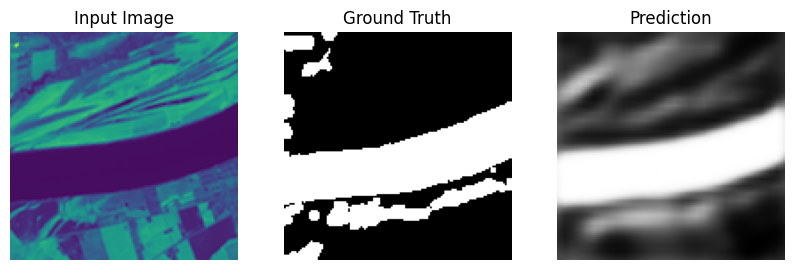

In [29]:
# Get one image from the test set
sample_image, sample_mask = test_dataset[31]
prediction = predict(model3, sample_image, device)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(sample_image.permute(1, 2, 0)[:, :, 6])
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sample_mask.squeeze().numpy(), cmap='gray')
plt.title("Ground Truth")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(prediction , cmap='gray')
plt.title("Prediction")
plt.axis('off')

plt.show()

In [30]:
model4 = smp.Unet(
    encoder_name= 'resnet34',
    encoder_weights='imagenet',
    in_channels=13,
    classes=1,
    activation=None,
)

In [31]:
model4.to(device)

train_losses = []
val_losses = []
val_dices = []

optimizer = torch.optim.Adam(model4.parameters(), lr=0.001)

for epoch in range(num_epochs):
    train_loss = train_model(model4, train_loader, criterion, optimizer, device)
    val_loss, val_dice = evaluate_model(model4, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_dices.append(val_dice)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val dice: {val_dice:.4f}")

# Evaluate on test set
test_loss, test_dice = evaluate_model(model4, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}, Test dice: {test_dice:.4f}")

/tmp/ipython-input-14-1550219719.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(self.images[idx]).clone().detach().float().permute(2, 0, 1)  # (C,H,W)
/tmp/ipython-input-14-1550219719.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(self.masks[idx]).clone().detach().float().unsqueeze(0)  # (1,H,W)


Epoch 1/50: Train Loss: 0.4985, Val Loss: 0.9807, Val dice: 0.3660
Epoch 2/50: Train Loss: 0.3192, Val Loss: 2.1263, Val dice: 0.4501
Epoch 3/50: Train Loss: 0.2774, Val Loss: 0.7140, Val dice: 0.3722
Epoch 4/50: Train Loss: 0.2603, Val Loss: 0.2920, Val dice: 0.5149
Epoch 5/50: Train Loss: 0.2976, Val Loss: 0.3182, Val dice: 0.5318
Epoch 6/50: Train Loss: 0.2548, Val Loss: 0.3318, Val dice: 0.5138
Epoch 7/50: Train Loss: 0.2281, Val Loss: 0.2484, Val dice: 0.5504
Epoch 8/50: Train Loss: 0.2374, Val Loss: 0.3187, Val dice: 0.5163
Epoch 9/50: Train Loss: 0.2115, Val Loss: 0.2521, Val dice: 0.5311
Epoch 10/50: Train Loss: 0.2422, Val Loss: 0.3262, Val dice: 0.5415
Epoch 11/50: Train Loss: 0.2743, Val Loss: 0.2657, Val dice: 0.5288
Epoch 12/50: Train Loss: 0.2316, Val Loss: 0.2474, Val dice: 0.5148
Epoch 13/50: Train Loss: 0.2201, Val Loss: 0.3026, Val dice: 0.5315
Epoch 14/50: Train Loss: 0.2239, Val Loss: 0.2830, Val dice: 0.5390
Epoch 15/50: Train Loss: 0.2069, Val Loss: 0.3038, Val di

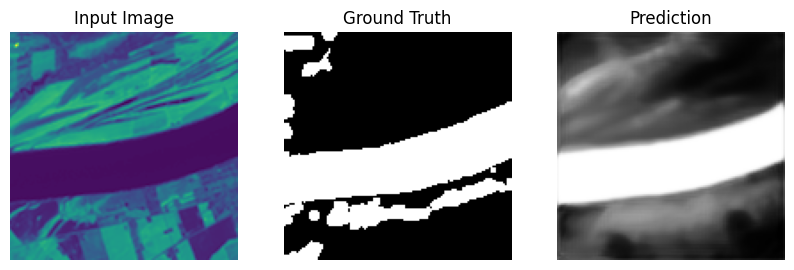

In [32]:
# Get one image from the test set
sample_image, sample_mask = test_dataset[31]
prediction = predict(model4, sample_image, device)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(sample_image.permute(1, 2, 0)[:, :, 6])
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sample_mask.squeeze().numpy(), cmap='gray')
plt.title("Ground Truth")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(prediction , cmap='gray')
plt.title("Prediction")
plt.axis('off')

plt.show()

In [33]:
model5 = smp.PSPNet(
    encoder_name= 'resnet34',
    encoder_weights='imagenet',
    in_channels=13,
    classes=1,
    activation=None,
)

In [34]:
model5.to(device)

train_losses = []
val_losses = []
val_dices = []

optimizer = torch.optim.Adam(model5.parameters(), lr=0.001)

for epoch in range(num_epochs):
    train_loss = train_model(model5, train_loader, criterion, optimizer, device)
    val_loss, val_dice = evaluate_model(model5, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_dices.append(val_dice)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val dice: {val_dice:.4f}")

# Evaluate on test set
test_loss, test_dice = evaluate_model(model5, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}, Test dice: {test_dice:.4f}")

/tmp/ipython-input-14-1550219719.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(self.images[idx]).clone().detach().float().permute(2, 0, 1)  # (C,H,W)
/tmp/ipython-input-14-1550219719.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(self.masks[idx]).clone().detach().float().unsqueeze(0)  # (1,H,W)


Epoch 1/50: Train Loss: 0.3798, Val Loss: 0.3615, Val dice: 0.4572
Epoch 2/50: Train Loss: 0.3043, Val Loss: 0.6153, Val dice: 0.3843
Epoch 3/50: Train Loss: 0.2827, Val Loss: 0.4789, Val dice: 0.3938
Epoch 4/50: Train Loss: 0.2586, Val Loss: 0.3469, Val dice: 0.4584
Epoch 5/50: Train Loss: 0.2708, Val Loss: 0.3417, Val dice: 0.3995
Epoch 6/50: Train Loss: 0.2685, Val Loss: 0.3051, Val dice: 0.5106
Epoch 7/50: Train Loss: 0.2753, Val Loss: 0.3125, Val dice: 0.4884
Epoch 8/50: Train Loss: 0.2580, Val Loss: 0.2809, Val dice: 0.5023
Epoch 9/50: Train Loss: 0.2838, Val Loss: 0.2653, Val dice: 0.4829
Epoch 10/50: Train Loss: 0.2527, Val Loss: 0.3774, Val dice: 0.4505
Epoch 11/50: Train Loss: 0.2979, Val Loss: 0.3247, Val dice: 0.4985
Epoch 12/50: Train Loss: 0.2904, Val Loss: 0.3168, Val dice: 0.4728
Epoch 13/50: Train Loss: 0.2816, Val Loss: 0.3265, Val dice: 0.5135
Epoch 14/50: Train Loss: 0.2524, Val Loss: 0.3735, Val dice: 0.4528
Epoch 15/50: Train Loss: 0.2482, Val Loss: 0.2653, Val di

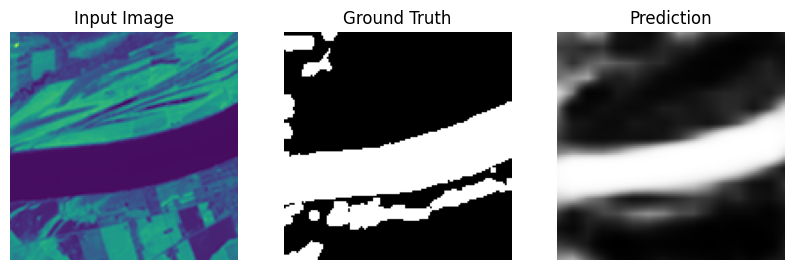

In [35]:
# Get one image from the test set
sample_image, sample_mask = test_dataset[31]
prediction = predict(model5, sample_image, device)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(sample_image.permute(1, 2, 0)[:, :, 6])
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sample_mask.squeeze().numpy(), cmap='gray')
plt.title("Ground Truth")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(prediction , cmap='gray')
plt.title("Prediction")
plt.axis('off')

plt.show()

In [36]:
model6 = smp.Segformer(
    encoder_name= 'resnet34',
    encoder_weights='imagenet',
    in_channels=13,
    classes=1,
    activation=None,
)

In [37]:
model6.to(device)

train_losses = []
val_losses = []
val_dices = []

optimizer = torch.optim.Adam(model6.parameters(), lr=0.001)

for epoch in range(num_epochs):
    train_loss = train_model(model6, train_loader, criterion, optimizer, device)
    val_loss, val_dice = evaluate_model(model6, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_dices.append(val_dice)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val dice: {val_dice:.4f}")

# Evaluate on test set
test_loss, test_dice = evaluate_model(model6, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}, Test dice: {test_dice:.4f}")

/tmp/ipython-input-14-1550219719.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(self.images[idx]).clone().detach().float().permute(2, 0, 1)  # (C,H,W)
/tmp/ipython-input-14-1550219719.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(self.masks[idx]).clone().detach().float().unsqueeze(0)  # (1,H,W)


Epoch 1/50: Train Loss: 0.5401, Val Loss: 13.5099, Val dice: 0.3545
Epoch 2/50: Train Loss: 0.3409, Val Loss: 45.8286, Val dice: 0.1539
Epoch 3/50: Train Loss: 0.3481, Val Loss: 1.2663, Val dice: 0.4269
Epoch 4/50: Train Loss: 0.2571, Val Loss: 1.8435, Val dice: 0.3916
Epoch 5/50: Train Loss: 0.2693, Val Loss: 0.2839, Val dice: 0.5187
Epoch 6/50: Train Loss: 0.2413, Val Loss: 0.2820, Val dice: 0.5463
Epoch 7/50: Train Loss: 0.2376, Val Loss: 0.2873, Val dice: 0.5013
Epoch 8/50: Train Loss: 0.2674, Val Loss: 0.6358, Val dice: 0.4601
Epoch 9/50: Train Loss: 0.2275, Val Loss: 0.3561, Val dice: 0.4888
Epoch 10/50: Train Loss: 0.2395, Val Loss: 0.2345, Val dice: 0.5130
Epoch 11/50: Train Loss: 0.2131, Val Loss: 0.2791, Val dice: 0.5042
Epoch 12/50: Train Loss: 0.2086, Val Loss: 0.2662, Val dice: 0.5408
Epoch 13/50: Train Loss: 0.1968, Val Loss: 0.2320, Val dice: 0.5778
Epoch 14/50: Train Loss: 0.2255, Val Loss: 0.2868, Val dice: 0.5660
Epoch 15/50: Train Loss: 0.2021, Val Loss: 0.3310, Val 

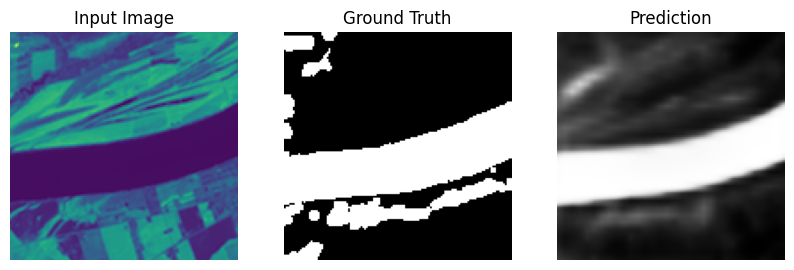

In [38]:
# Get one image from the test set
sample_image, sample_mask = test_dataset[31]
prediction = predict(model6, sample_image, device)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(sample_image.permute(1, 2, 0)[:, :, 6])
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sample_mask.squeeze().numpy(), cmap='gray')
plt.title("Ground Truth")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(prediction , cmap='gray')
plt.title("Prediction")
plt.axis('off')

plt.show()

In [39]:
model7 = smp.UnetPlusPlus(
    encoder_name= 'resnet34',
    encoder_weights='imagenet',
    in_channels=13,
    classes=1,
    activation=None,
)

In [40]:
model7.to(device)

train_losses = []
val_losses = []
val_dices = []

optimizer = torch.optim.Adam(model7.parameters(), lr=0.001)

for epoch in range(num_epochs):
    train_loss = train_model(model7, train_loader, criterion, optimizer, device)
    val_loss, val_dice = evaluate_model(model7, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_dices.append(val_dice)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val dice: {val_dice:.4f}")

# Evaluate on test set
test_loss, test_dice = evaluate_model(model7, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}, Test dice: {test_dice:.4f}")

/tmp/ipython-input-14-1550219719.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(self.images[idx]).clone().detach().float().permute(2, 0, 1)  # (C,H,W)
/tmp/ipython-input-14-1550219719.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(self.masks[idx]).clone().detach().float().unsqueeze(0)  # (1,H,W)


Epoch 1/50: Train Loss: 0.5700, Val Loss: 10.6358, Val dice: 0.3604
Epoch 2/50: Train Loss: 0.3757, Val Loss: 0.4459, Val dice: 0.4542
Epoch 3/50: Train Loss: 0.3062, Val Loss: 0.3894, Val dice: 0.4887
Epoch 4/50: Train Loss: 0.2687, Val Loss: 0.3619, Val dice: 0.5108
Epoch 5/50: Train Loss: 0.2462, Val Loss: 0.3512, Val dice: 0.5384
Epoch 6/50: Train Loss: 0.2336, Val Loss: 0.3014, Val dice: 0.5331
Epoch 7/50: Train Loss: 0.2163, Val Loss: 0.2600, Val dice: 0.5768
Epoch 8/50: Train Loss: 0.2440, Val Loss: 0.2528, Val dice: 0.5794
Epoch 9/50: Train Loss: 0.2494, Val Loss: 0.3540, Val dice: 0.5303
Epoch 10/50: Train Loss: 0.2567, Val Loss: 0.6549, Val dice: 0.5061
Epoch 11/50: Train Loss: 0.2885, Val Loss: 0.3076, Val dice: 0.5225
Epoch 12/50: Train Loss: 0.2519, Val Loss: 0.3269, Val dice: 0.5309
Epoch 13/50: Train Loss: 0.2114, Val Loss: 0.3271, Val dice: 0.5618
Epoch 14/50: Train Loss: 0.2028, Val Loss: 0.2700, Val dice: 0.5630
Epoch 15/50: Train Loss: 0.2038, Val Loss: 0.2865, Val d

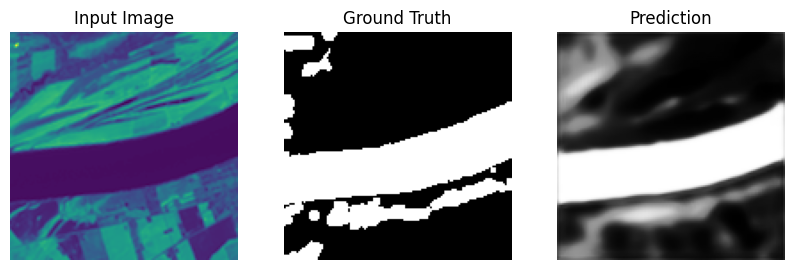

In [41]:
# Get one image from the test set
sample_image, sample_mask = test_dataset[31]
prediction = predict(model7, sample_image, device)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(sample_image.permute(1, 2, 0)[:, :, 6])
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sample_mask.squeeze().numpy(), cmap='gray')
plt.title("Ground Truth")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(prediction , cmap='gray')
plt.title("Prediction")
plt.axis('off')

plt.show()

In [42]:
# the best model is Linknet with 0.67 Dice coef
torch.save(model2.state_dict(), 'linknet.pth')